In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import tensorflow
import pickle

In [8]:
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
train_df = pd.read_csv('./drive/MyDrive/Genre Classification Dataset/train_data.txt', sep=':::',engine='python', header=None)
train_df.columns = ['id','title','genre','description']
train_df.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [11]:
test_df = pd.read_csv('./drive/MyDrive/Genre Classification Dataset/test_data_solution.txt', sep=':::',engine='python', header=None)
test_df.columns = ['id','title', 'genre','description']
test_df.head()

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [12]:
train_df.shape, test_df.shape

((54214, 4), (54200, 4))

In [13]:
train_df.isnull().sum(), test_df.isnull().sum()

(id             0
 title          0
 genre          0
 description    0
 dtype: int64, id             0
 title          0
 genre          0
 description    0
 dtype: int64)

In [14]:
len(train_df.genre.unique()), len(test_df.genre.unique())

(27, 27)

In [15]:
num_classes = len(train_df.genre.unique())

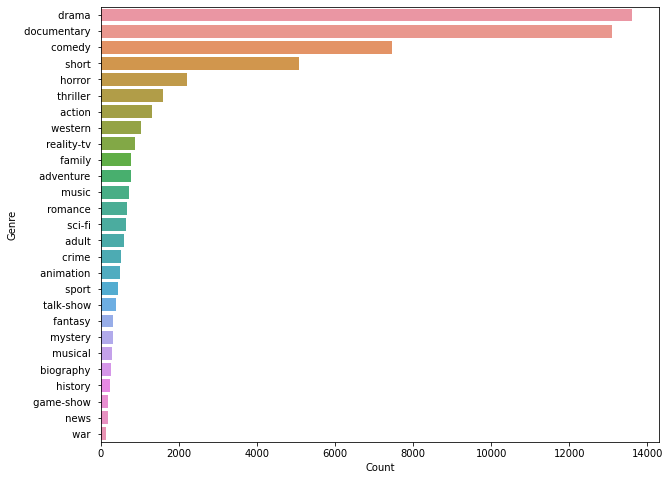

In [16]:
plt.figure(figsize=(10,8))
genreCount = train_df.genre.value_counts()
sns.barplot(x = genreCount, y = genreCount.index)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

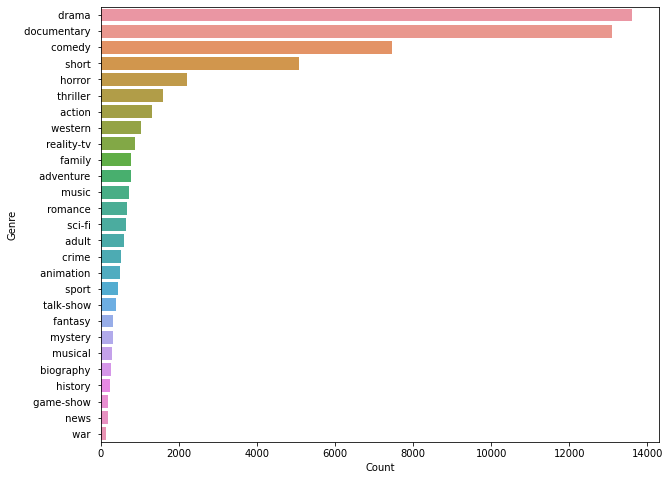

In [17]:
plt.figure(figsize=(10,8))
genreCount = test_df.genre.value_counts()
sns.barplot(x = genreCount, y = genreCount.index)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [18]:
train_df['lengthBeforeProcessing'] = train_df.description.apply(len)
train_df.head()

,id,title,genre,description,lengthBeforeProcessing
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


In [19]:
test_df['lengthBeforeProcessing'] = test_df.description.apply(len)
test_df.head()

,id,title,genre,description,lengthBeforeProcessing
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",510
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",674
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,590
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",681
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...,814


In [20]:
wordnet_lemmatizer = WordNetLemmatizer()

In [21]:
def text_cleaner(text):
    # lower-case all characters
    text = text.lower()
    # remove urls
    text =  re.sub(r'http\S+', '',text)
    text =  re.sub(r'www\S+', '',text)                  
    # only keeps characters
    text =  re.sub(r"[^a-zA-Z+]", ' ',text)
    # keep words with length>1 only
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')
    #remove punctuation marks
    text = "".join([i for i in text if i not in string.punctuation])
    #tokenize
    words = nltk.tokenize.word_tokenize(text)
    #lemmatize
    lemmatizedWords = [wordnet_lemmatizer.lemmatize(i) for i in words]
    #remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in lemmatizedWords if i not in stopwords])
    #strip spaces
    text= re.sub("\s[\s]+", " ",text).strip()
    return text

In [22]:
train_df['cleanedDescription'] = train_df.description.apply(text_cleaner)
test_df['cleanedDescription'] = test_df.description.apply(text_cleaner)

In [23]:
train_df['lengthAfterProcessing'] = train_df.cleanedDescription.apply(len)
test_df['lengthAfterProcessing'] = test_df.cleanedDescription.apply(len)

In [24]:
train_df.head()

,id,title,genre,description,lengthBeforeProcessing,cleanedDescription,lengthAfterProcessing
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listening conversation doctor parent year old ...,378
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestuous relationship cu...,117
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty student field trip museum natural hi...,388
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemployed father make end meet edith twi...,732
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film title refers un recovered body ground zer...,399


In [25]:
train_df.lengthAfterProcessing.mean()

403.1817242778618

In [26]:
X_train,X_val,y_train,y_val = train_test_split(train_df.cleanedDescription,train_df.genre,test_size=0.1,random_state=42)

In [27]:
X_train.shape, X_val.shape

((48792,), (5422,))

## Support Vector Machine

In [ ]:
clf = Pipeline([
        ('vect', CountVectorizer(ngram_range=(1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', LinearSVC(C=100))
    ])
clf = clf.fit(X_train, y_train)

# Post Hyperparameter tuning

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
predicted = clf.predict(X_val)
prediction_acc = np.mean(predicted == y_val)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 60.18074511250461 %


In [ ]:
from joblib import dump, load
dump(clf, 'svc.joblib')

['svc.joblib']

### Prediction with test data

In [ ]:
predicted = clf.predict(test_df.cleanedDescription)
prediction_acc = np.mean(predicted == test_df.genre)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 60.46125461254612 %


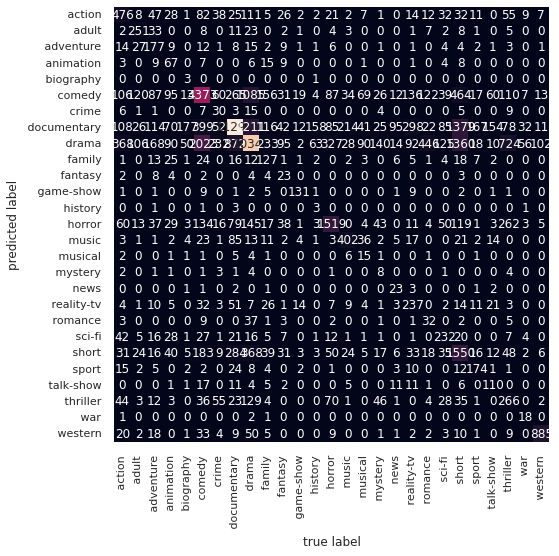

In [ ]:
mat = confusion_matrix(test_df.genre, predicted)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_df.genre),
            yticklabels=np.unique(test_df.genre))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
print(metrics.classification_report(test_df.genre, predicted, zero_division=0))

               precision    recall  f1-score   support

      action        0.45      0.36      0.40      1314
       adult        0.69      0.43      0.53       590
   adventure        0.59      0.23      0.33       775
   animation        0.52      0.13      0.21       498
   biography        0.75      0.01      0.02       264
      comedy        0.57      0.59      0.58      7446
       crime        0.37      0.06      0.10       505
 documentary        0.69      0.86      0.76     13096
       drama        0.57      0.76      0.65     13612
      family        0.47      0.16      0.24       783
     fantasy        0.46      0.07      0.12       322
   game-show        0.79      0.68      0.73       193
     history        0.33      0.01      0.02       243
      horror        0.58      0.69      0.63      2204
       music        0.62      0.55      0.58       731
     musical        0.38      0.05      0.10       276
     mystery        0.30      0.03      0.05       318
        n

## LGBM

In [ ]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         learning_rate = 0.1,
                         num_leaves=31, 
                         max_depth=-1, 
                         n_estimators=100, 
                         objective='multiclass', 
                         n_jobs= -1)

In [ ]:
#After Hyperparameter tuning
text_clf = Pipeline([
        ('vect', CountVectorizer(ngram_range = (1,2))),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)
    ])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier(objective='multiclass'))])

In [ ]:
dump(text_clf, 'lgb_clf.joblib')

['lgb_clf.joblib']

In [ ]:
predicted = text_clf.predict(X_val)
prediction_acc = np.mean(predicted == y_val)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 52.47141276281815 %


### Prediction with Test Data

In [ ]:
predicted = text_clf.predict(test_df.cleanedDescription)
prediction_acc = np.mean(predicted == test_df.genre)
print("Overall: " + str(prediction_acc*100),"%")

Overall: 53.31734317343173 %


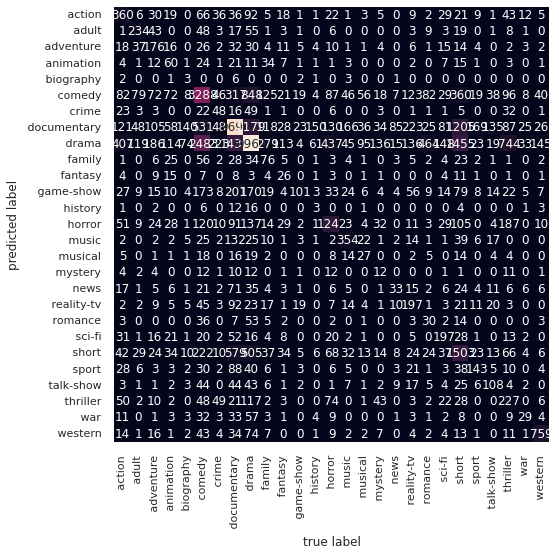

In [ ]:
mat = confusion_matrix(test_df.genre, predicted)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_df.genre),
            yticklabels=np.unique(test_df.genre))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
print(metrics.classification_report(test_df.genre, predicted, zero_division=0))

               precision    recall  f1-score   support

      action        0.43      0.27      0.34      1314
       adult        0.51      0.40      0.45       590
   adventure        0.42      0.23      0.29       775
   animation        0.28      0.12      0.17       498
   biography        0.16      0.01      0.02       264
      comedy        0.55      0.44      0.49      7446
       crime        0.22      0.10      0.13       505
 documentary        0.66      0.74      0.70     13096
       drama        0.51      0.73      0.60     13612
      family        0.27      0.10      0.14       783
     fantasy        0.26      0.08      0.12       322
   game-show        0.10      0.52      0.17       193
     history        0.06      0.01      0.02       243
      horror        0.58      0.56      0.57      2204
       music        0.53      0.48      0.51       731
     musical        0.19      0.10      0.13       276
     mystery        0.14      0.04      0.06       318
        n

## Deep Learning - LSTM



In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [29]:
num_words = 50000
max_len = 200
tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(train_df['cleanedDescription'].values)

In [30]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [31]:
X_t = tokenizer.texts_to_sequences(X_train.values)
X_t = pad_sequences(X_t, maxlen=max_len)

X_v = tokenizer.texts_to_sequences(X_val.values)
X_v = pad_sequences(X_v, maxlen=max_len)


y_t = pd.get_dummies(y_train).values
y_v = pd.get_dummies(y_val).values

In [32]:
X_t.shape[1]

200

In [33]:
EMBEDDING_DIM = 32
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X_t.shape[1]))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
history = model.fit(X_t, y_t, epochs=3, batch_size=32, validation_data = (X_v, y_v))

Epoch 1/3
1525/1525 [==============================] - 25s 12ms/step - loss: 2.0561 - accuracy: 0.4036 - val_loss: 1.7542 - val_accuracy: 0.4911
Epoch 2/3
1525/1525 [==============================] - 18s 12ms/step - loss: 1.5479 - accuracy: 0.5558 - val_loss: 1.6470 - val_accuracy: 0.5148
Epoch 3/3
1525/1525 [==============================] - 18s 11ms/step - loss: 1.2530 - accuracy: 0.6398 - val_loss: 1.6482 - val_accuracy: 0.5374


In [ ]:
# model.save('lstm_classifier')

In [35]:
model.save_weights('lstm_checkpoint')

In [36]:
model.load_weights('./lstm_checkpoint')

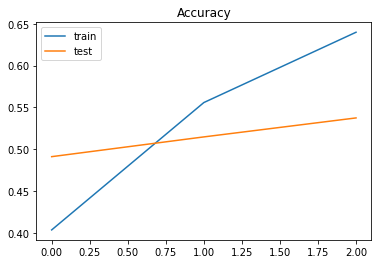

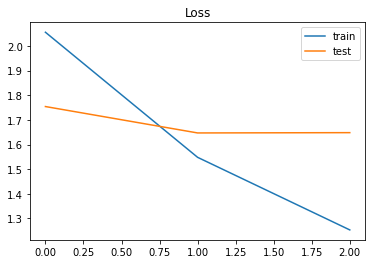

In [37]:
# Plotting Accuracy and val_accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Plotting loss and val_loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

### Prediction with Test data

In [38]:
X_te = tokenizer.texts_to_sequences(test_df.cleanedDescription.values)
X_te = pad_sequences(X_te, maxlen=max_len)

y_te = pd.get_dummies(test_df.genre).values

In [39]:
results = model.evaluate(X_te, y_te, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.61645
Test Accuracy: 54.42%


In [42]:
predicted = np.argmax(model.predict(X_te), axis = 1)

In [45]:
labels = list(pd.get_dummies(y_train).columns)
predicted = [labels[i] for i in predicted]

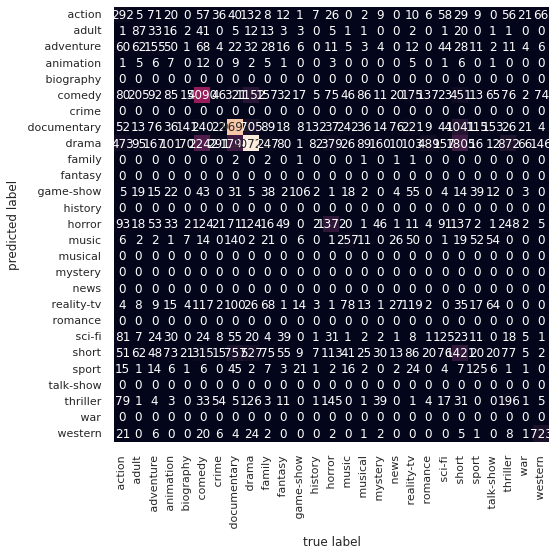

In [46]:
mat = confusion_matrix(test_df.genre, predicted)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_df.genre),
            yticklabels=np.unique(test_df.genre))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [47]:
print(metrics.classification_report(test_df.genre, predicted, zero_division=0))

               precision    recall  f1-score   support

      action        0.30      0.22      0.26      1314
       adult        0.35      0.15      0.21       590
   adventure        0.24      0.20      0.22       775
   animation        0.11      0.01      0.02       498
   biography        0.00      0.00      0.00       264
      comedy        0.54      0.55      0.55      7446
       crime        0.00      0.00      0.00       505
 documentary        0.73      0.74      0.74     13096
       drama        0.52      0.79      0.63     13612
      family        0.25      0.00      0.01       783
     fantasy        0.00      0.00      0.00       322
   game-show        0.24      0.55      0.33       193
     history        0.00      0.00      0.00       243
      horror        0.54      0.62      0.58      2204
       music        0.38      0.35      0.37       731
     musical        0.00      0.00      0.00       276
     mystery        0.00      0.00      0.00       318
        n

## Export Labels for Reverse Encoding

In [40]:
labels = list(pd.get_dummies(y_train).columns)

In [41]:
with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)